## Data acquisition and analysis

### Aquisition
The source we use for the pictures: https://www.kaggle.com/datasets/kacpergregorowicz/house-plant-species?resource=download
From here, we have chosen the following type of plants: Aloe_Vera, Chienese_Money_Plant, Elephant_Ear

• After downloading each of them into a different directory, their name was 1.jpg, 2.jpg, etc.
We wanted to store all of them in the same directory, so to handle this we needed to rename them. Thats why they got the names of Aloe_Vera_n.jpg, Elephant_Eat_n.jpg, etc.

• Also, they had other extensions: jpg, jpeg, png, JPG, webp. We chosed to accept the first 4.

• After the pictures was in the right place and structure, we generated a labels.csv that store the 'image names' and 'the claster they belong to' in a row.

In [61]:
!pip install -q pandas
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q torch
!pip install -q torchvision
!pip install -q pytorch_lightning
!pip install -q torchmetrics

In [62]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import matplotlib.pyplot as plt
import wandb
import pandas as pd
from PIL import Image
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import random
from torchvision.io import read_image

In [63]:
random.seed(42)
#directory = 'D:\\BME\\_MSC\\2_felev\\DL\\'
directory = 'images'
labels_file_path = 'labels.csv'
# directory = '/app/images'
# labels = '/app/labels.csv'

In [64]:
files = os.listdir(directory)
ratios = []
classes = {"aloe_vera": 0, "chinese_money_plant": 0, "elephant_ear": 0}
# Iterate through each file
for file in files:
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png") or file.endswith(".JPG"):
        # Open the image
        try:
            with Image.open(os.path.join(directory, file)) as img:
                name = '_'.join(file.split('_')[:-1])
                if name == 'Aloe_Vera':
                    classes["aloe_vera"] += 1
                elif name == 'Chinese_Money_Plant':
                    classes["chinese_money_plant"] += 1
                elif name == 'Elephant_Ear':
                    classes["elephant_ear"] += 1
                # Get original dimensions
                width, height = img.size
                ratio = width / height
                ratios.append(ratio)

        except Exception as inst:
            print(file + "could not be opened")
            continue
        finally:
            img.close()

    else:
        print(f"Skipping {file}: Not the expected extension")


occurrences = {item: ratios.count(item) for item in ratios}

Skipping Elephant_Ear_24.webp: Not the expected extension
Skipping Chinese_Money_Plant_75.webp: Not the expected extension
Skipping Chinese_Money_Plant_339.Jpg: Not the expected extension
Skipping Elephant_Ear_159.webp: Not the expected extension
Skipping Elephant_Ear_99.webp: Not the expected extension
Skipping Elephant_Ear_191.webp: Not the expected extension
Skipping Aloe_Vera_75.webp: Not the expected extension
Skipping Chinese_Money_Plant_60.Jpg: Not the expected extension
Skipping Aloe_Vera_42.webp: Not the expected extension
Skipping Elephant_Ear_222.webp: Not the expected extension
Skipping Aloe_Vera_185.jpe: Not the expected extension
Skipping Elephant_Ear_330.webp: Not the expected extension
Skipping Elephant_Ear_29.webp: Not the expected extension
Skipping Aloe_Vera_132.webp: Not the expected extension
Skipping Aloe_Vera_187.webp: Not the expected extension


### Analysis

1) We have calculated the ratio of the pictures, and searched for the most common ones in the dataset.
The following histogram plots it: 1.0 is the most common, that is why we decided to use it as default. Our oppinion is that if a picture is a bit misshapen that does not affect the solution. We tested the ideal for this margin of error and keep the pictures between 0.6 and 1.2 ratio. (To have enough of them for training.)

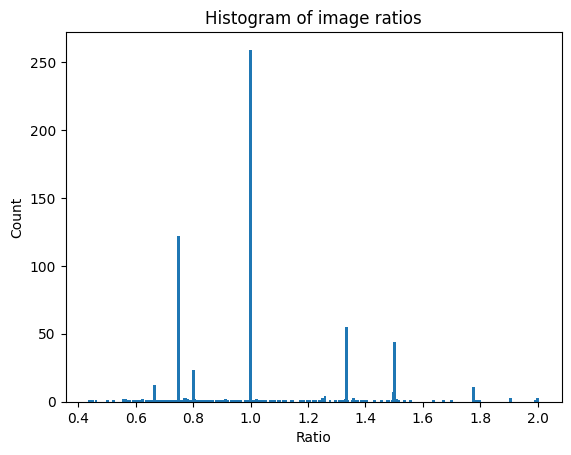

In [65]:

# Extracting keys and values
keys = list(occurrences.keys())
values = list(occurrences.values())

# Plotting the histogram
plt.bar(keys, values, width=0.01)
plt.xlabel('Ratio')
plt.ylabel('Count')
plt.title('Histogram of image ratios')
plt.show()

# as it seen in the histogram, the most common type is 1.0, and around that -> so we choose to convert the images into 1:1 ratio

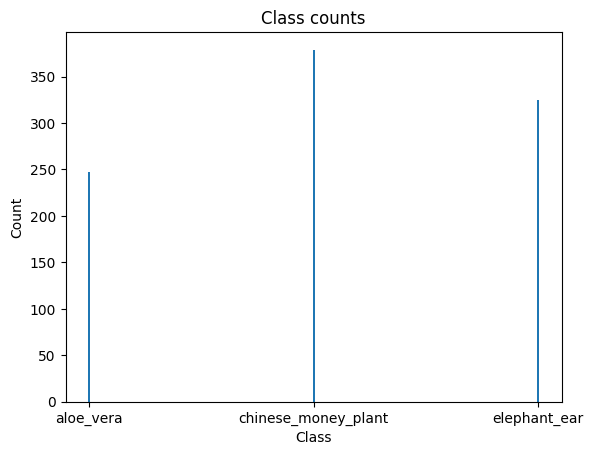

In [66]:
# Extracting keys and values
keys = list(classes.keys())
values = list(classes.values())

# Plotting the histogram
plt.bar(keys, values, width=0.01)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class counts')
plt.show()

### Data cleaning and preparation

1) For preparation, we resized each of the pictures to the same. It has 1.0 ratio as we earlier discussed. We would like to pick a number of pixels below 100. (This ensures, that the training won't be extremely slow.)
For cleaning, we dropped the ones where the ratio was under 0.6 or above 1.2, so where it was not fit into the condition we assigned to keeping them.

In [67]:
files = os.listdir(directory)
df = pd.DataFrame(columns=['Id', 'Label'])
for file in files:
  if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png") or file.endswith(".JPG"):
    # Open the image
    try:
      with Image.open(os.path.join(directory, file)) as img:
        img.verify()
        # Get original dimensions
        width, height = img.size
        ratio = width / height
        if ratio > 0.6 and ratio < 1.2:
          dictionary={}
          name = '_'.join(file.split('_')[:-1])
          if name == 'Aloe_Vera':
            cl = 0
          elif name == 'Chinese_Money_Plant':
            cl = 1
          elif name == 'Elephant_Ear':
            cl = 2
          dictionary['Id'] = file
          dictionary['Label'] = cl
          new_row = pd.DataFrame([dictionary])
          df = pd.concat([df, new_row], ignore_index=True)
        else:
          print(f"Skipping {file}: Dimensions ratio do not match (expected between 0.6 and 1.2)")

    except IOError as inst:
      print(file + f"could not be opened:{inst}")
      os.remove(os.path.join(directory, file))
      continue


  else:
    print(f"Skipping {file}: Not the expected extension")

df.to_csv(labels_file_path, index=False)

Skipping Elephant_Ear_67.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Chinese_Money_Plant_155.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Chinese_Money_Plant_200.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Chinese_Money_Plant_33.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Aloe_Vera_149.jpeg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Elephant_Ear_283.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Aloe_Vera_79.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Aloe_Vera_136.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Aloe_Vera_57.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Aloe_Vera_58.jpg: Dimensions ratio do not match (expected between 0.6 and 1.2)
Skipping Chinese_Money_Plant_214.jpg: Dimensions ratio do not match (expected 

In [118]:
resolution = 80
num_classes = 3
batch_size = 32
num_workers = 0

num_epochs = 5
num_epochs_baseline = 10
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [105]:
class PlantImageDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform):
        _labels = pd.read_csv(labels_file)
        self.img_labels = _labels
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'{self.img_labels.iloc[idx, 0]}')
        image = Image.open(img_path).convert('RGB')
        #image = read_image(img_path)
        if self.transform is not None:
            try:
                image = self.transform(image)
            except Exception as error:
                print(error)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [104]:
class SubsetWithTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [71]:
pds = PlantImageDataset(directory, labels_file_path, transform=transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.75, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()]))
generator1 = torch.Generator().manual_seed(42)
splits = random_split(pds, [0.8, 0.1, 0.1], generator=generator1)
trainloader = (DataLoader(pds, batch_size=batch_size, shuffle=True))
valloader = (DataLoader(splits[1], batch_size=batch_size))
testloader = (DataLoader(splits[2], batch_size=batch_size))

In [72]:
mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0.0

for data, _ in trainloader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [73]:
mean, std

(tensor([0.5452, 0.5786, 0.4690]), tensor([0.2294, 0.2116, 0.2503]))

In [107]:
class PlantsDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.75, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    # def preprocess_train(self, batch):
    #     batch["image"] = [self.train_transform(image) for image in batch["image"]]
    #     return batch

    # def preprocess_val(self, batch):
    #     batch["image"] = [self.val_transform(image) for image in batch["image"]]
    #     return batch

    def setup(self, stage=None):
        pds = PlantImageDataset(directory, labels_file_path, None)
        #pds = PlantImageDataset(directory, labels_file_path, self.train_transform)
        generator1 = torch.Generator().manual_seed(42)
        splits = random_split(pds, [0.8, 0.1, 0.1], generator=generator1)
        #self.train_dataset = pds
        self.train_dataset = SubsetWithTransform(splits[0], self.train_transform)
        self.val_dataset = SubsetWithTransform(splits[1], self.val_transform)
        self.test_dataset = SubsetWithTransform(splits[2], self.val_transform)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

In [116]:
datamodule = PlantsDataModule()
datamodule.setup()

In [123]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.confusionmatrix = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=num_classes)
        self.per_class_accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes, average="none")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        #pred_labels = self(batch["image"])
        pred_labels = self(batch[0])

        # loss = F.cross_entropy(pred_labels, batch["label"])
        # accuracy = self.accuracy(pred_labels, batch["label"])
        loss = F.cross_entropy(pred_labels, batch[1])
        accuracy = self.accuracy(pred_labels, batch[1])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch[0])

        #calculating metrics
        loss = F.cross_entropy(pred_labels, batch[1])
        accuracy = self.accuracy(pred_labels, batch[1])
        confusionmatrix = self.confusionmatrix(pred_labels, batch[1])
        per_class_acc = self.per_class_accuracy(pred_labels, batch[1])

        #logging metrics
        for i in range(num_classes):
            self.log(f'val_acc_class_{i}', per_class_acc[i], prog_bar=True)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)



        return {"val_loss": loss}


    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        #return torch.optim.Adam(self.parameters(), lr=learning_rate)
        return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)


In [109]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.ReLU(),
    torch.nn.BatchNorm2d(width),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)

In [110]:
logger = pl.loggers.TensorBoardLogger("logs/", name="insurance_regression_logs")

In [124]:
baseline_model = ImageClassifier(model)

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs_baseline,
    precision="16-mixed", #gyorsabb így mintha 32 bites floatot hsanzálnánk
    accelerator="gpu",
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
    log_every_n_steps=3
)
trainer.fit(baseline_model, datamodule)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/insurance_regression_logs/version_3/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type                      | Params | Mode 
-------------------------------------------------------------------------
0 | model              | Sequential                | 76.2 K | eval 
1 | accuracy           | MulticlassAccuracy        | 0      | train
2 | confusionmatrix    | MulticlassConfusionMatrix | 0      | train

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [125]:
trainer.validate(baseline_model, datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.6428571343421936     │
│      val_acc_class_0      │    0.5485714673995972     │
│      val_acc_class_1      │    0.6571428775787354     │
│      val_acc_class_2      │    0.6609523892402649     │
│         val_loss          │    0.8068362474441528     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc_class_0': 0.5485714673995972,
  'val_acc_class_1': 0.6571428775787354,
  'val_acc_class_2': 0.6609523892402649,
  'val_loss': 0.8068362474441528,
  'val_acc': 0.6428571343421936}]

In [126]:
trainer.test(baseline_model, datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.6666666865348816     │
│         test_loss         │    0.7276346683502197     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7276346683502197, 'test_acc': 0.6666666865348816}]

Since we are performing multiclass classification we are aiming to maximize per class accuracy.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

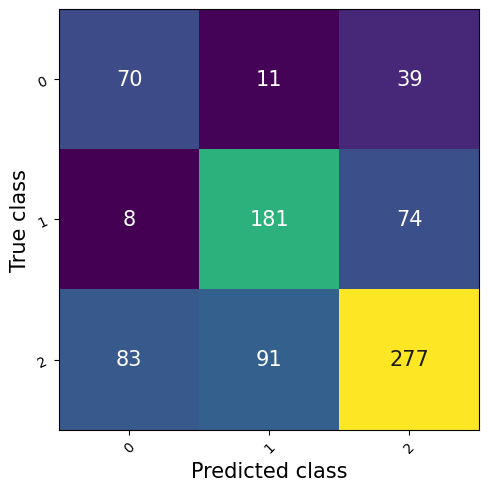

In [127]:
baseline_model.confusionmatrix.plot()

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassAccuracy'>)

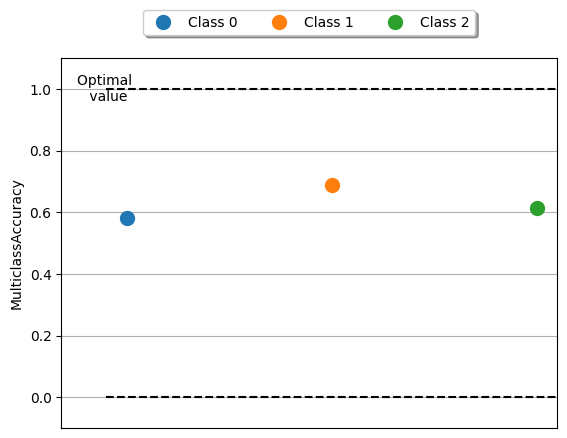

In [131]:
baseline_model.per_class_accuracy.plot()